In [1]:
SOURCE_MARKDOWN = """
**Subject: The Wordpress vs WP Engine Drama**

In a surprising twist of events, the open-source giant WordPress is entangled in a dramatic controversy surrounding its licensing policies aimed squarely at WP Engine, stirring fierce discussions across the web. **"How can you expect any goodwill towards open-source from a community when you insist on enforcing fees?"** This quote captures the mounting frustration many in the tech community feel as these events unfold.

**Background Context**  
WordPress, an open-source content management system, has thrived on its community-driven model for years. However, recently, the organization faced backlash due to new licensing fee structures selectively impacting WP Engine, a leading managed Wordpress host. This move has raised concerns among other hosting companies and developers about potential instability and implications for open-source projects.

---

**The Emergence of Tension**  
The friction began to surface as Automattic, the parent company of WordPress, targeted WP Engine for allegedly not contributing enough to the WordPress ecosystem. **James Ivings** pointed out in one of his tweets, *“You can’t go IPO with just a happy customer base, you need to be extracting profits from the entire market (via licensing).”* This sentiment echoes the belief that the motives behind the licensing changes extend beyond simply supporting the open-source initiative. ([source](https://twitter.com/jamesivings/status/1839422193681481750))

---

**Mixed Reactions Among Developers**  
As the news broke, reaction from the community was polarized. While some developers supported Automattic's actions as a means to ensure sustainable growth, others voiced concerns about stifling innovation and creating a hostile environment for open source. One developer remarked that experienced consequences, like **“Being blocked from installing plugins,”** could negatively impact WP Engine's customer base and, subsequently, WordPress's reputation as a stable and reliable platform. ([source](https://twitter.com/arvidkahl/status/1839445536686174387))

---

**The Financial Perspective**  
Conversations centered around revenue models emerged, as seen in **Danny Postmaa's** reflections on his experiences, *"more growth != more support tickets."* He noted that despite their expanding user base, support requests remained steady, indicating a deeper complexity in managing resources amid growth. ([source](https://twitter.com/dannypostmaa/status/1839847665338925293))

There’s a growing belief that this drama could lead to significant changes in how hosting services operate with WordPress, resulting in a shift towards licensing strategies that others, like NewFoldDigital, have already embraced. Many felt securing licensing is a smart strategic move, potentially raising the licensing fees for all WP hosting partners. ([source](https://twitter.com/jessethanley/status/1839569215000588641))

---

**Community Support and Reactions**  
While the turmoil has pushed various developers to share their thoughts online, there’s a palpable sense of disbelief among users and developers alike. The unforeseen changes raise questions about open-source integrity, As **Arvid Kahl** noted, emphasizing the need for transparency from Automattic in their reasoning. *“I hope the ecosystem is self-healing. I just hope WPE being blocked from installing can be healed without causing massive reputational damage,”* he expressed. ([source](https://twitter.com/arvidkahl/status/1839445536686174387))

---

In conclusion, the **WordPress vs. WP Engine drama** reveals not just a licensing issue but digs into the larger questions surrounding the sustainability of open-source models and the balance of growth, community trust, and corporate influence. As this saga unfolds, the tech community watches closely, ready to respond.
"""


In [2]:
from typing import Literal, Optional, List, Union
from pydantic import BaseModel, Field

STORYBOARD_PROMPT = """
I will provide you with a source string that represents a news article.

Your job is to create a storyboard for a video that will be generated from the news article.

The storyboard should be an array of objects, where each object represents a starting frame for a video, which will then be animated to create a video segment with a fixed duration.

Don't put two of the same type in a row, and use at least one of each type.

I will also supply a total duration for the video, generate enough frames to fill the duration given a duration of 2 seconds for each frame. Print out the total number of frames you will generate.
"""


TYPE_DESCRIPTION = {
    "meme": "a meme image, that will be animated",
    "twitter_screenshot": "a screenshot of a twitter thread",
    "stock_video": "a stock video based on an initial image",
}


STOCK_IMAGE_DESCRIPTION = """
A description of an image that will be used as a prompt to generate a stock image. We want the image to be photo realistic, showing a scene that matches the source markdown in some way.
"""


class StoryboardItem(BaseModel):
    type: Literal["meme", "twitter_screenshot", "stock_video"] = Field(
        ..., description=str(TYPE_DESCRIPTION)
    )
    stock_image_description: Union[str, None] = Field(
        ..., description=STOCK_IMAGE_DESCRIPTION
    )
    twitter_url: Union[str, None] = Field(
        ...,
        description="The url of the twitter thread to screenshot if the type is twitter_screenshot. Leave blank if the type is not twitter_screenshot. Make sure the tweet is in the source markdown.",
    )


class Storyboard(BaseModel):
    items: List[StoryboardItem] = Field(..., description="The storyboard items")
    total_duration: int = Field(
        ..., description="The total duration of the video in seconds"
    )
    total_frames: int = Field(
        ..., description="The total number of frames in the video"
    )


In [3]:
import os
from openai import OpenAI
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Initialize OpenAI client
client = OpenAI()

TOTAL_DURATION = 10

# Call OpenAI API with GPT-4 Turbo
response = client.beta.chat.completions.parse(
    model="gpt-4o-2024-08-06",
    messages=[
        {"role": "system", "content": STORYBOARD_PROMPT},
        {"role": "user", "content": SOURCE_MARKDOWN},
        {
            "role": "user",
            "content": f"The total duration of the video is {TOTAL_DURATION} seconds.",
        },
    ],
    response_format=Storyboard,
)

# Extract the generated storyboard
storyboard = response.choices[0].message.parsed


print("Storyboard: ")
print("Duration: ", storyboard.total_duration)
print("Total Frames: ", storyboard.total_frames)
for item in storyboard.items:
    print(item)


Storyboard: 
Duration:  10
Total Frames:  5
type='meme' stock_image_description='A cracked open laptop screen showing WordPress logo breaking into pieces, symbolizing the licensing controversy.' twitter_url=None
type='twitter_screenshot' stock_image_description=None twitter_url='https://twitter.com/jamesivings/status/1839422193681481750'
type='stock_video' stock_image_description='A group of developers in a heated discussion at a modern office setting, showcasing mixed reactions and tension.' twitter_url=None
type='twitter_screenshot' stock_image_description=None twitter_url='https://twitter.com/arvidkahl/status/1839445536686174387'
type='meme' stock_image_description='An image of a tug of war between WordPress and WP Engine, with dollar signs in the background, illustrating financial struggles.' twitter_url=None


In [10]:
%reload_ext autoreload
%autoreload 2


import aiohttp


IDEOGRAM_URL = "https://api.ideogram.ai/generate"

IDEOGRAM_HEADERS = {
    "Api-Key": os.getenv("IDEOGRAM_API_KEY"),
    "Content-Type": "application/json",
}


async def generate_ideo_image(prompt: str, starting_image_url: Optional[str] = None):
    image_request = {
        "image_request": {
            "prompt": prompt,
            "model": "V_2",
            "magic_prompt_option": "AUTO",
            "aspect_ratio": "ASPECT_16_9"
        }
    }

    if starting_image_url:
        image_request["image_request"]["keyframe"] = {
            "frame0": {"type": "image", "url": starting_image_url}
        }

    async with aiohttp.ClientSession() as session:
        async with session.post(
            IDEOGRAM_URL, json=image_request, headers=IDEOGRAM_HEADERS
        ) as response:
            return await response.json()


In [5]:
from tweetcapture import TweetCapture
import asyncio


import os

async def capture_tweet(url, port):
    try:
        tweet = TweetCapture()
        tweet.add_chrome_argument(f"--remote-debugging-port={port}")
        
        # Create 'tweets' directory if it doesn't exist
        os.makedirs('tweets', exist_ok=True)
        
        # Generate a filename based on the URL and username
        username = url.split('/')[-3]  # Assuming the URL format is twitter.com/username/status/id
        filename = f"tweets/{username}_{url.split('/')[-1]}.png"
        
        await tweet.screenshot(url, path=filename, overwrite=True)
        return filename
    except Exception as e:
        print(f"Error capturing tweet {url}: {str(e)}")
        return None


async def capture_tweets(tweet_urls):
    port = 9222
    tasks = []
    for url in tweet_urls:
        tasks.append(asyncio.create_task(capture_tweet(url, port)))
        port += 1

    filenames = []
    for task in asyncio.as_completed(tasks):
        try:
            filename = await task
            if filename:
                filenames.append(filename)
        except Exception as e:
            print(f"Error processing task: {str(e)}")

    return filenames







In [6]:
from lumaai import AsyncLumaAI
import time

MAX_ATTEMPTS = 30
POLL_INTERVAL = 5

client = AsyncLumaAI()

async def generate_luma_video(prompt: Optional[str] = None, start_image_url: Optional[str] = None, aspect_ratio: str = "16:9" ):
    generation = await client.generations.create(
        prompt=prompt,
        keyframes={
            "frame0": {
                "type": "image",
                "url": start_image_url
            }
        } if start_image_url else {},
        aspect_ratio=aspect_ratio
    )
    return generation.id

async def poll_generation(generation_id, max_attempts=MAX_ATTEMPTS, delay=POLL_INTERVAL):
    for attempt in range(max_attempts):
        print(f"Attempt {attempt + 1}/{max_attempts} to poll generation {generation_id}")
        status = await client.generations.get(generation_id)
        print(f"Current status: {status.state}")
        if status.state == "completed":
            print(f"Generation {generation_id} completed successfully")
            return status
        elif status.state == "failed":
            print(f"Generation {generation_id} failed")
            raise Exception(f"Generation failed: {status.failure_reason}")
        
        print(f"Waiting {delay} seconds before next attempt")
        time.sleep(delay)

    print(f"Max attempts ({max_attempts}) reached for generation {generation_id}")
    raise Exception("Max attempts reached")

In [11]:
import os
from pyairtable import Api
api = Api(os.environ['AIRTABLE_API_KEY'])
table = api.table('appi0R6F1ckhy8JpZ', 'table1')

# Reformat the data
records = table.all()

# Reformat the data
reformatted_data = {}

for record in records:
    name = record['fields'].get('Name', '')
    notes = record['fields'].get('Notes', '')
    image_url = ''
    
    # Get the first image URL if available
    if 'image' in record['fields'] and record['fields']['image']:
        image_url = record['fields']['image'][0].get('url', '')
    
    reformatted_data[name] = {
        'notes': notes,
        'image_url': image_url
    }


import asyncio
import json

class ImageUrl(BaseModel):
    url: str


async def process_video(item):
    if item.type == "twitter_screenshot":
        raise ValueError("Twitter screenshots dont make videos")
    elif item.type == "stock_video":
        ideogram_response = await generate_ideo_image(item.stock_image_description)
        print("ideogram_response", ideogram_response)
        luma_video_id = await generate_luma_video(prompt=None, 
                                            start_image_url=ideogram_response['data'][0]['url'])
        
    elif item.type == "meme":
        dict_memes = json.dumps(reformatted_data)
        model_response = client.beta.chat.completions.parse(
            model="gpt-4o-2024-08-06",
            messages=[
                {"role": "system", "content": "You are a helpful assistant"},
                {"role": "user", "content": f"Given the following memes {dict_memes}, give the closest matching meme URL to a smart professor"},
            ],
            response_format=ImageUrl,
        )
        meme_url = model_response.choices[0].message.parsed
        luma_video_id = await generate_luma_video(prompt=None, start_image_url=meme_url.url)
    result = await poll_generation(luma_video_id)
    return result



async def fetch_all_resources(processed_items):
    tweet_urls = [item.twitter_url for item in processed_items if item.type == 'twitter_screenshot']
    image_items = [item for item in processed_items if item.type in ['stock_video', 'meme']]

    tweet_tasks = [capture_tweets(tweet_urls)] if tweet_urls else []
    image_tasks = [process_video(item) for item in image_items]
    results = await asyncio.gather(*tweet_tasks, *image_tasks)

    tweet_files = results[0] if tweet_urls else []
    print("tweet_files", tweet_files, tweet_urls)
    video_results = results[1:] if image_items else []

    return tweet_files, video_results

async def main():
    tweet_files, video_results = await fetch_all_resources(storyboard.items)


    combined_resources = []

    tweet_index = 0
    image_index = 0

    for item in storyboard.items:
        if item.type == 'twitter_screenshot' :

            tweet_id = item.twitter_url.split("/")[-1]
  
            if any(tweet_id in tweet_file for tweet_file in tweet_files):
                combined_resources.append({
                    "type": "twitter_screenshot",
                    "file_path": tweet_files[tweet_index]
                })
                tweet_index += 1
        elif item.type in ['stock_video', 'meme']:
            combined_resources.append({
                "type": item.type,
                "result": video_results[image_index]
            })
            image_index += 1

    print("Combined resources in storyboard order:")
    print(combined_resources)
    return combined_resources

combined_resources = await main()



ideogram_response {'created': '2024-09-28T21:17:59.160412+00:00', 'data': [{'is_image_safe': True, 'prompt': "A cartoon image of a tug of war game between WordPress and WP Engine. On one side, there's a WordPress mascot with a blue shirt and on the other side, a WP Engine mascot with a red shirt. They are pulling a lever with a dollar sign. The background is a room with a table and chairs. There are more dollar signs on the ground. The lighting is soft.", 'resolution': '1312x736', 'seed': 163114093, 'style_type': 'GENERAL', 'url': 'https://ideogram.ai/api/images/ephemeral/ySma_EUuSzae7BtEIS2Xew.png?exp=1727644698&sig=4fb8facb5a7eb397dfc99970b5b659271f1b79d891da2ac1d891be1732de716e'}]}
ideogram_response {'created': '2024-09-28T21:17:59.155653+00:00', 'data': [{'is_image_safe': True, 'prompt': 'A photo of a group of developers in a modern office setting, engaged in a heated discussion. There is a mix of reactions and tension among the developers. One developer is pointing to a screen, wh

https://storage.cdn-luma.com/lit_lite_inference_v1.6-xl/9fe01ef3-a2be-440d-b116-b8e48ecd46eb/e2f4a545-3bfe-4298-9116-f74e7ab86ec5_video06c8a250da17c45cfae451696e50f5edc.mp4


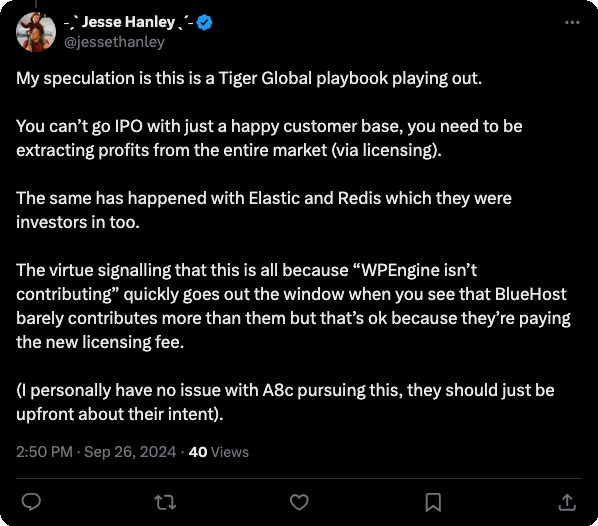

https://storage.cdn-luma.com/lit_lite_inference_v1.6-xl/17c3ec5e-85b0-4a63-91fd-13fb4d1d100d/e3e9ad87-e75e-420d-ae2a-f93fda84fdd4_video08d30d7818e634270a0cd750ce81a868b.mp4


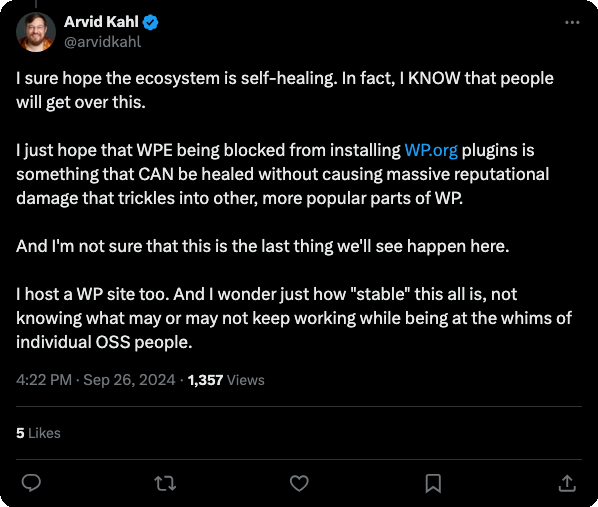

https://storage.cdn-luma.com/lit_lite_inference_v1.6-xl/c0ded75d-7473-40ea-a03a-01ed542c7932/5a51c557-01bb-4e54-bc76-40d79a6fd7ca_video02ee53ba8bd8b438797895371bf350b8e.mp4


In [12]:
from IPython.display import Image

for resource in combined_resources:
    if resource["type"] == "twitter_screenshot":
        display(Image(resource["file_path"]))
    elif resource["type"] == "stock_video" or resource["type"] == "meme":
        print(resource["result"].assets.video)

